In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import time
import gym

import osmnx as ox
import folium

from gym import Env
from gym import utils
from gym.spaces import Discrete, Box
from stable_baselines3.common.env_checker import check_env
from IPython.display import clear_output
from shapely.geometry import Polygon
import csv

In [9]:
# Construct the boundary of the map using a polygon 
boundary = Polygon([(-122.75593463884833, 38.48043857931626), (-122.75593463884833, 38.44276212966626), 
                    (-122.71602508838065, 38.44276212966626), (-122.71602508838065, 38.48043857931626)])

# create graph ---> driving network 
graph = ox.graph.graph_from_polygon(boundary, network_type = 'drive')
# Use undirected graph (understand details of this)
graph = graph.to_undirected()
# Add edge speeds 
graph = ox.speed.add_edge_speeds(graph, precision = 3)
graph = ox.speed.add_edge_travel_times(graph, precision = 3)
# Get nodes and edges 
nodes, edges = ox.graph_to_gdfs(graph)

# Drop attributes
edges = edges.drop(columns = ['osmid', 'bridge', 'oneway', 'lanes', 'maxspeed', 
                              'geometry', 'ref', 'name'])
# Visualize edge information 
edges

# Visualize road network
m = ox.plot_graph_folium(graph, popup_attribute = 'travel_time', weight = 3, color = '#3498DB')
m

In [10]:
id_list = []

for n in range(len(graph)):
    id_list.append(nodes.iloc[n].name)
    if id_list[n] == 56102877:
        print(n)
    if id_list[n] == 1965862095:
        print(n)

489
752


In [21]:
import requests

url = "https://air-quality.p.rapidapi.com/history/airquality"

querystring = {"lon":"-122.716025","lat":"38.48"}

headers = {
    'x-rapidapi-host': "air-quality.p.rapidapi.com",
    'x-rapidapi-key': "2cf8feefbemsh97a86d388fdbd52p199821jsn94a154efc9f4"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

#print(response.json()['data'][0]['aqi'])
center_nodes = [56021878, 56116949, 56093141, 56141841, 55973814, 2816793484, 56024733, 56030101]
#print(nodes.iloc[id_list.index(56021878)].x)
aqi_arr = []
for center in center_nodes:
    querystring["lon"] = str(nodes.iloc[id_list.index(center)].x)
    querystring["lat"] = str(nodes.iloc[id_list.index(center)].y)
    response = requests.request("GET", url, headers=headers, params=querystring)
    aqi_arr.append(response.json()['data'][0]['aqi'])
aqi_arr

[100.4, 100.4, 100.4, 100.4, 100.4, 100.4, 100.4, 100.4]

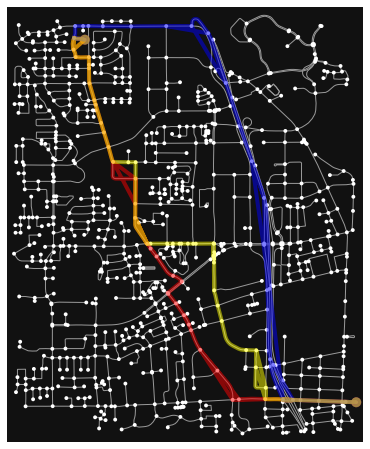

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
colors = ['red', 'blue', 'yellow']

sample_paths = []

sample_paths.append(list(ox.distance.shortest_path(graph, 56102877, 1965862095, weight = 'length')))
sample_paths.append(list(ox.distance.shortest_path(graph, 56102877, 1965862095, weight = 'travel_time')))
sample_paths.append([56102877, 6940021052, 56102875, 56043223, 56102872, 55973175, 56004921, 55950049, 55950051, 56125037, 56125038, 56078315, 56040934, 56084803, 56084797, 7049377524, 7049377523, 7049377522, 7049377521, 7049377518, 56116115, 56116919, 56116921, 56116923, 8268741787, 56019308, 56021878, 7204303428, 56116927, 56157636, 56034980, 56129707, 56054706, 56097568, 56129711, 56117906, 56140110, 56055340, 56173132, 56102741, 56109019, 56027403, 56043321, 56101250, 56040774, 56017692, 56040783, 1965862095])

ox.plot.plot_graph_routes(graph, sample_paths, route_colors = colors)
nodes1 = pd.DataFrame(nodes)

In [5]:
class PathEnv(gym.Env):
    
    # Define metadata
    metadata = {'render.modes': ['human']}
    
    # Define constants
    PATH = sample_paths[1]  
    
    def __init__(self):
        super(PathEnv, self).__init__()
        
        # Initialize agent starting node
        self.agent_node = 489 # 489
        
        self.t_diff = 0
        
        # Initialize previous agent node
        self.prev_agent_node = self.agent_node 
        
        # Initialize agent path
        self.agent_path = [self.agent_node]
        
        # Initialize goal node
        self.goal_node = 752 # 752
        
        # Initialize goal time
        self.goal_time = self.get_path_time(self.PATH)
        
        # Initialize time elapsed
        self.time_elapsed = 0
        
        # Define action and observation spaces
        n_actions = len(graph)
        self.action_space = Discrete(n_actions)
        self.observation_space = Discrete(n_actions)
        
        # initialize previous distance to goal variable 
        self.prev_dist = 10000000.0
    
    def step(self, action):
        
        done = False
        reward = 0
        if action in self.get_neighbor_indices():

            # Update previous agent node, agent node, agent path
            self.prev_agent_node = self.agent_node
            self.agent_node = action
            
            # Not sure if I need this ---> first test with, next test without  
            #if action in self.agent_path:
            #    reward -= 10
                
            # Update agent path
            self.agent_path.append(action)
            
            # Update time elapsed
            self.time_elapsed += graph.edges[(id_list[self.prev_agent_node], id_list[self.agent_node], 0)]['travel_time'] + 30
            
            # Get new distance to goal
            dist = self.get_distance_to_goal()
            
            if dist < self.prev_dist:
                reward = 1
                self.prev_dist = dist
            else:
                reward = -1
                self.prev_dist = dist
            
        else:
            print('Illegal action')
            done = True
            
        if self.goal_reached():
            done = True

            # Define reward
            error = abs(self.goal_time - (self.time_elapsed/60)) 
            self.t_diff += error
            reward -= error
            reward += 10000
            
        # Set placeholder for info
        info = {}
        
        # Return step information
        n_state = self.agent_node
        return n_state, reward, done, info

    def render(self, mode = 'human'):
        if mode != 'human':
            raise NotImplementedError()
        
        ox.plot.plot_graph_route(graph, self.get_id_path(self.agent_path))
        
    def reset(self):
        
        # Initialize agent starting node
        self.agent_node = 489 
        
        self.t_diff = 0
        
        # Initialize previous agent node
        self.prev_agent_node = self.agent_node
        
        # Initialize agent path
        self.agent_path = [self.agent_node]
        
        # Initialize goal node
        self.goal_node = 752 
        
        # Initialize goal time
        self.goal_time = self.get_path_time(self.PATH)
        
        # Initialize time elapsed
        self.time_elapsed = 0
        
        # initialize state 
        n_state = self.agent_node
        
        # initialize previous distance to goal 
        self.prev_dist = 1000000.0
        
        return n_state
    
    # Get indices of neighbors to current node
    def get_neighbor_indices(self):
        id = id_list[self.agent_node]

        neighbors = list(graph.neighbors(id))
        neighbor_indices = []

        for i in range(len(id_list)):
            for n in neighbors:
                if n == id_list[i]:
                    neighbor_indices.append(i)

        return neighbor_indices
    
    # Get ID path from index path
    def get_id_path(self, path):
        id_path = path.copy()
        
        for n in range(len(id_path)):
            id_path[n] = id_list[id_path[n]]
        
        return id_path
    
    # Get index path from ID path
    def get_index_path(self, path):
        index_path = path.copy()
        
        for n in range(len(index_path)):
            index_path[n] = id_list.index(index_path[n])
        
        return index_path
    
    # Get path time of given path
    def get_path_time(self, path):
        path_time = 0
        
        for n in range(len(path) - 1):
            path_time += graph.edges[(path[n], path[n + 1], 0)]['travel_time'] + 30
        
        return path_time/60
    
    # Get path distance of given path
    def get_path_distance(self, path):
        path_dist = 0
        
        for n in range(len(path) - 1):
            path_dist += graph.edges[(path[n], path[n + 1], 0)]['length']
        
        return path_dist
    
    # Get path accuracy info
    def get_path_accuracy(self, sample, agent):
        matching_edges = 0
        sample_edges = []
        agent_edges = []
        
        for i in range(len(sample) - 1):
            sample_edges.append((sample[i], sample[i + 1]))
            
        for i in range(len(agent) - 1):
            agent_edges.append((agent[i], agent[i + 1]))
            
        
        for edge in sample_edges:
            if edge in agent_edges:
                matching_edges += 1
        
        print('Matching edges: {} / {}'.format(matching_edges, len(sample)))
        print('Length difference:', abs(len(sample) - len(agent)))
        
        accuracy_score = (matching_edges / len(sample)) * 100 - abs(len(sample) - len(agent))
        
        print('Edge accuracy score:', accuracy_score)
        
        return accuracy_score
                
    # Get agent's distance to goal
    def get_distance_to_goal(self):
        p = ox.distance.shortest_path(graph, id_list[self.agent_node], id_list[self.goal_node], weight = 'length')
        
        return self.get_path_distance(p)

    def get_best_action(self):
        q_vals = []

        neighbors = self.get_neighbor_indices()

        for n in neighbors:
            q_vals.append(q_table[state, n])

        return neighbors[random.choice(np.argwhere(q_vals == np.max(q_vals)).flatten().tolist())]

    # Returns true if agent has reached goal
    def goal_reached(self):
        if self.agent_node == self.goal_node:
            return True
        else:
            return False
        
    def get_time_diff(self):
        return self.t_diff

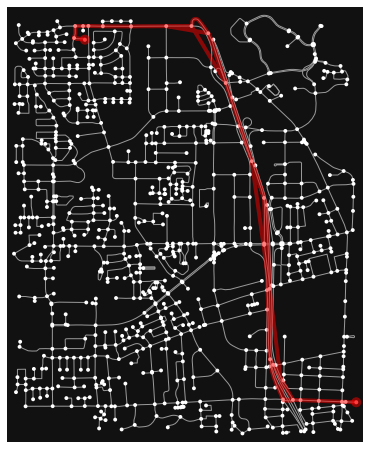

Episode finished.
Goal time: 15.75
Time elapsed: 945.09
Score: 10021.0
Average score: 10021.0
Sample path:


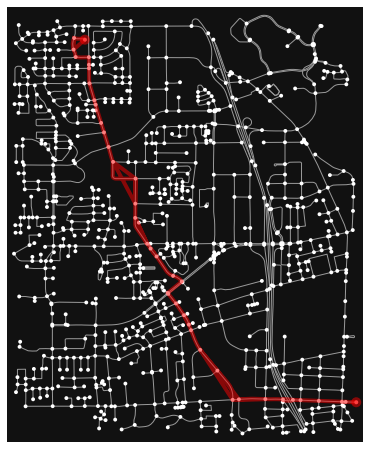

Agent path:


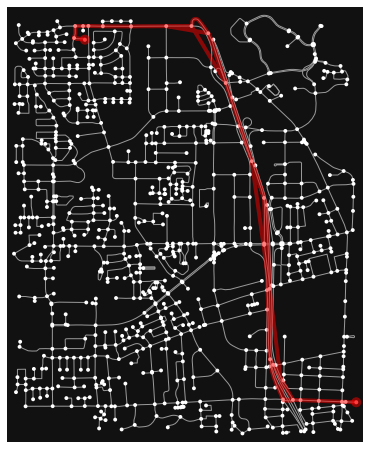

Matching edges: 7 / 40
Length difference: 18
Edge accuracy score: -0.5


In [6]:
alpha = [.0001, .001, .01, .1, .2, .5]
gamma = [.999, .99, .95, .9, .8, .5]
num_episodes = 400
max_steps = 2000

data = open('RL_Data2.csv', 'w', newline='')
fieldnames = ['alpha', 'gamma', 'path_accuracy', 'time_difference', 'path', 'optimal_rewards_over_episodes', 'max_rewards_over_episodes', 'agent_path']
writer = csv.DictWriter(data, fieldnames=fieldnames)
writer.writeheader()

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

for a in alpha:
    for g in gamma:
        
        env = PathEnv()
        check_env(env, warn = True) 
        env.reset()
        env.render()
        action_size = env.action_space.n
        state_size = env.observation_space.n
        q_table = np.zeros((state_size, action_size))
        
        rewards_all_episodes = []
        q_table_list = []
        episode_history = []

        # Q-Learning algorithm
        for episode in range(num_episodes):
            clear_output(wait = True)
            print('Episode', episode, '/', num_episodes)
    
            step_history = []
    
            state = env.reset()
            done = False
            rewards_current_episode = 0
    
            for step in range (max_steps):
                exploration_rate_threshold = random.uniform(0, 1)
        
                if exploration_rate_threshold > exploration_rate:
                    action = env.get_best_action()
                else:
                    action = random.choice(env.get_neighbor_indices())
        
                n_state, reward, done, info = env.step(action)
        
                step_history.append(action)
        
                # Update Q-table for Q(s, a)
                q_table[state, action] = q_table[state, action] * (1 - a) + \
                    a * (reward + g * np.max(q_table[n_state, :]))
        
                state = n_state
                rewards_current_episode += reward
                reached_goal = env.goal_reached()
       
                if done:
                    if(reached_goal):
                        print("reached goal")
                        print()
                    else:
                        print("Did not reach goal")
                        print()
                    break
            
            # exploration rate decay 
            if episode < 200:
                exploration_rate = min_exploration_rate + \
                    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
            elif episode == 200:
                exploration_rate = 0.5
        
            else:
                exploration_rate *= .99
    
            # Save history 
            rewards_all_episodes.append(rewards_current_episode)
            episode_history.append(step_history)
    
            # Save Q-table every episode
            q_table_list.append(q_table.copy())
            
            
        rewards_per_hundred_episodes = np.split(np.array(rewards_all_episodes), num_episodes / 100)
        count = 100

        print('Rewards per hundred episodes')
        print('-----------------------------')
        for r in rewards_per_hundred_episodes:
            print(count, ":", round(sum(r / 100), 1))
            count += 100
                
        print('------------------------------')
        filename = 'q_table_temporal_br2_a=' + str(a) + 'g=' + str(g) + '.npy'
        np.save(filename, q_table)
        q_table = np.load(filename)
            
            
        # ----------------------------------------------------------------------
            
        num_ep = len(q_table_list)
        max_st = 100
        history = []
            
        for episode in range(num_episodes):
            clear_output(wait = True)
            print('Episode', episode, '/', num_episodes)
    
            q_table = q_table_list[episode].copy()
        
            state = env.reset()
            done = False
            score = 0
                
            for step in range(max_steps):
                action = env.get_best_action()
                n_state, reward, done, info = env.step(action)
                score += reward
                state = n_state
        
                if done:
                    break
    
            history.append(score)
        
        plt.plot(history)
        plt.ylabel('Reward')
        plt.xlabel('Episode')
        plt.savefig('optimal_rewards_temporal_path2_a=' + str(a) + 'g=' + str(g) + '.png')
        
        optimal = history.index(max(history)) #TO EXCEL
             
         
        plt.plot(rewards_all_episodes)
        plt.ylabel('Reward')
        plt.xlabel('Episode')
        plt.savefig('testing_rewards_path2_a=' + str(a) + 'g=' + str(g) + '.png')
                
        max_rewards = rewards_all_episodes.index(max(rewards_all_episodes)) # TO EXCEL
        
        episodes = 1
        max_steps = 100
        history = []

       
        for episode in range(1, episodes + 1):
            state = env.reset()
            done = False
            score = 0
    
            clear_output(wait = True)
            env.render()
            time.sleep(0.5)
    
            for step in range(max_steps):
                action = env.get_best_action()
                print('Action:', action)
                n_state, reward, done, info = env.step(action)
                score += reward
                state = n_state
        
                clear_output(wait = True)
                env.render()
        
                if done:
                    print('Episode finished.')
                    print('Goal time:', round(env.goal_time, 2))
                    print('Time elapsed:', round(env.time_elapsed, 2))
                    print('Score:', round(score, 2))
                    time.sleep(2)
                    break
            
            if not done:
                print('Goal not reached in {} steps.'.format(max_steps), 'Score:', round(score, 1))
                time.sleep(2)
    
            history.append(score)

        print('Average score:', round(sum(history) / len(history), 2))
        env.close() 
                    
                    
        print('Sample path:')
        ox.plot.plot_graph_route(graph, sample_paths[0])
        print('Agent path:')
        ox.plot.plot_graph_route(graph, env.get_id_path(env.agent_path))
        
        writer.writerow({'alpha': a, 'gamma':g, 'path_accuracy':env.get_path_accuracy(sample_paths[0], env.get_id_path(env.agent_path)),'time_difference':env.get_time_diff(),'optimal_rewards_over_episodes':optimal,'max_rewards_over_episodes':max_rewards, 'agent_path':env.get_id_path(env.agent_path)})          
data.close()                      